# BentoML Example: Keras Fashion MNIST

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. 

This notebook demonstrates how to use BentoML to turn a Keras model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=keras&ea=keras-fashion-mnist&dt=keras-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#!pip install bentoml
!pip install tensorflow==1.14.0 numpy matplotlib keras==2.3.1 pillow

In [3]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print("Tensorflow Version: %s" % tf.__version__)

import keras
print("Keras Version: %s" % keras.__version__)

import bentoml
print("BentoML Version: %s" % bentoml.__version__)

Tensorflow Version: 1.14.0
Keras Version: 2.3.1


Using TensorFlow backend.


BentoML Version: 0.8.3+47.g7af5a8f


## Load Fashion MNIST dataset

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

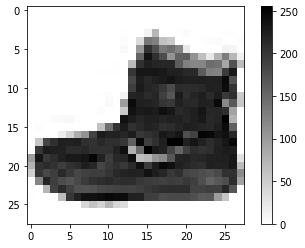

In [6]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We should scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [7]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

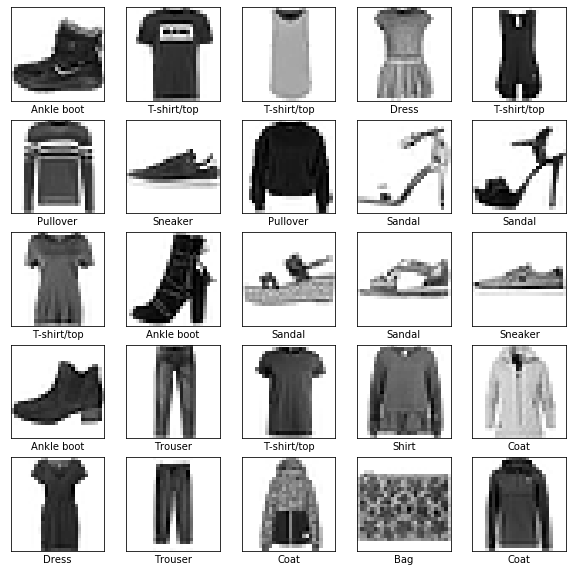

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [9]:
# Reshaping the images so that our model can accept it
train_images  = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

## Build the model

In [10]:
model = keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)            

## Compile the model

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [12]:
model.fit(train_images, train_labels, batch_size=64, epochs=5)


Epoch 1/5
60000/60000 [==============================] - 7s 117us/step - loss: 0.5991 - accuracy: 0.7797
Epoch 2/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.4139 - accuracy: 0.8503
Epoch 3/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.3687 - accuracy: 0.8659
Epoch 4/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.3423 - accuracy: 0.8751
Epoch 5/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.3203 - accuracy: 0.8814


## Evaluate model accuracy

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 62us/step
Test accuracy: 0.8956000208854675


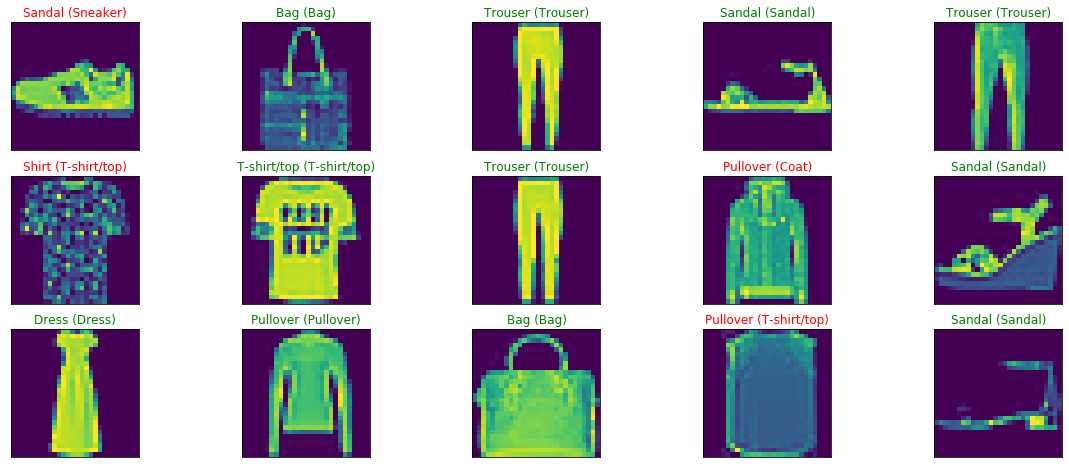

In [14]:
y_hat = model.predict_classes(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = y_hat[index]
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Predict on a single image

Let's first see the test image and and its label:

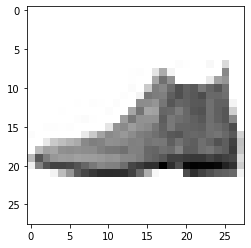

Class: Ankle boot


In [15]:
plt.imshow(test_images[0].squeeze(-1), cmap=plt.cm.binary)
plt.show()
print('Class:', class_names[test_labels[0]])

In [16]:
pred_idx = model.predict_classes(np.expand_dims(test_images[0], 0))[0]
print('Prediction:', class_names[pred_idx])

Prediction: Ankle boot


## Define BentoService for model serving

In [17]:
%%writefile keras_fashion_mnist.py

import numpy as np
from PIL import Image
from bentoml import api, artifacts, env, BentoService
from bentoml.artifact import KerasModelArtifact
from bentoml.adapters import ImageInput

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@env(pip_dependencies=['keras==2.3.1', 'tensorflow==1.14.0', 'pillow', 'numpy'])
@artifacts([KerasModelArtifact('classifier')])
class KerasFashionMnistService(BentoService):
        
    @api(input=ImageInput(pilmode='L'))
    def predict(self, imgs):
        inputs = []
        for img in imgs:
            img = Image.fromarray(img).resize((28, 28))
            img = np.array(img.getdata()).reshape((28, 28, 1))
            inputs.append(img)
        inputs = np.stack(inputs)
        class_idxs = self.artifacts.classifier.predict_classes(inputs)
        return [class_names[class_idx] for class_idx in class_idxs]

Overwriting keras_fashion_mnist.py


## Save BentoService to file archive

In [18]:
# 1) import the custom BentoService defined above
from keras_fashion_mnist import KerasFashionMnistService

# 2) `pack` it with required artifacts
mnist_svc = KerasFashionMnistService()
mnist_svc.pack('classifier', model)

# 3) save your BentoSerivce to file archive
saved_path = mnist_svc.save()

[2020-08-04 11:52:26,769] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.

[2020-08-04 11:52:40,069] INFO - Detect BentoML installed in development model, copying local BentoML module file to target saved bundle path
running sdist
running egg_info
writing BentoML.egg-info/PKG-INFO
writing dependency_links to BentoML.egg-info/dependency_links.txt
writing entry points to BentoML.egg-info/entry_points.txt
writing requirements to BentoML.egg-info/requires.txt
writing top-level names to BentoML.egg-info/top_level.txt
reading manifest file 'BentoML.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'


no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check
creating BentoML-0.8.3+47.g7af5a8f
creating BentoML-0.8.3+47.g7af5a8f/BentoML.egg-info
creating BentoML-0.8.3+47.g7af5a8f/bentoml
creating BentoML-0.8.3+47.g7af5a8f/bentoml/adapters
creating BentoML-0.8.3+47.g7af5a8f/bentoml/artifact
creating BentoML-0.8.3+47.g7af5a8f/bentoml/cli
creating BentoML-0.8.3+47.g7af5a8f/bentoml/clipper
creating BentoML-0.8.3+47.g7af5a8f/bentoml/configuration
creating BentoML-0.8.3+47.g7af5a8f/bentoml/configuration/__pycache__
creating BentoML-0.8.3+47.g7af5a8f/bentoml/handlers
creating BentoML-0.8.3+47.g7af5a8f/bentoml/marshal
creating BentoML-0.8.3+47.g7af5a8f/bentoml/saved_bundle
creating BentoML-0.8.3+47.g7af5a8f/bentoml/server
creating BentoML-0.8.3+47.g7af5a8f/bentoml/utils
creating BentoML-0.8.3+47.g7af5a8f/bentoml/yatai
creating BentoML-0.8.3+47.g7af5a8f/bentoml/yatai/client
creating BentoML-0.8.3+47.g7af5a8f/bentoml/yatai/deployment
creating BentoML-0.8.3+47.g7af5a8f/bentoml/yatai/dep

## Load BentoService from archive


In [37]:
svc = bentoml.load(saved_path)
svc.predict([test_images[0].squeeze(-1)])

[2020-08-04 11:40:53,595] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g7af5a8f
[2020-08-04 11:40:53,596] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.
[2020-08-04 11:40:53,597] WARNING - `load` on a 'packed' artifact may lead to unexpected behaviors
[2020-08-04 11:40:53,598] WARNING - `load` an artifact multiple times may lead to unexpected behaviors
[2020-08-04 11:40:54,787] WARNING - `pack` an artifact multiple times may lead to unexpected behaviors


['Ankle boot']

# "pip install" a BentoService archive

BentoML user can directly pip install saved BentoML archive with `pip install $SAVED_PATH`,  and use it as a regular python package.

In [27]:
!pip install --quiet {saved_path}

In [38]:
# Your bentoML model class name will become packaged name
import KerasFashionMnistService

ms = KerasFashionMnistService.load()
ms.predict([test_images[0].squeeze(-1)])

['Ankle boot']

# Use BentoService with BentoML CLI

List BentoService's all version with `bentoml get`

In [27]:
!bentoml get KerasFashionMnistService

BENTO_SERVICE                                   CREATED_AT        APIS                   ARTIFACTS
KerasFashionMnistService:20200206114430_94F93D  2020-02-06 19:44  predict::ImageHandler  classifier::KerasModelArtifact
KerasFashionMnistService:20200206113040_3B9AE5  2020-02-06 19:31  predict::ImageHandler  classifier::KerasModelArtifact


Use `bentoml get <ServiceName>:<ServiceVersion>` to get metadata and other details

In [4]:
!bentoml get KerasFashionMnistService:latest

[2020-08-04 11:45:33,082] INFO - Getting latest version KerasFashionMnistService:20200804114025_051A42
{
  "name": "KerasFashionMnistService",
  "version": "20200804114025_051A42",
  "uri": {
    "type": "LOCAL",
    "uri": "/home/bentoml/bentoml/repository/KerasFashionMnistService/20200804114025_051A42"
  },
  "bentoServiceMetadata": {
    "name": "KerasFashionMnistService",
    "version": "20200804114025_051A42",
    "createdAt": "2020-08-04T03:40:39.186043Z",
    "env": {
      "condaEnv": "name: bentoml-KerasFashionMnistService\nchannels:\n- defaults\ndependencies:\n- python=3.6.10\n- pip\n",
      "pipDependencies": "tensorflow==1.14.0\nimageio\nbentoml==0.8.3\nkeras\nPillow\nnumpy",
      "pythonVersion": "3.6.10",
      "dockerBaseImage": "bentoml/model-server:0.8.3"
    },
    "artifacts": [
      {
        "name": "classifier",
        "artifactType": "KerasModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "inputType": "ImageInput",
       

**With `bentoml run` we can quickly test and validate the prediction result with sample data**

In [1]:
!bentoml run KerasFashionMnistService:latest predict --input=sample_image.png

[2020-08-04 11:41:38,313] INFO - Getting latest version KerasFashionMnistService:20200804114025_051A42
[2020-08-04 11:41:39,278] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-04 11:41:39,312] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g7af5a8f
[2020-08-04 11:41:40,483] WARNING - Pillow package does not exist in the current python session
Using TensorFlow backend.
2020-08-04 11:41:40.595206: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2020-08-04 11:41:40.612103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

**Start a local realtime prediction service with `bentoml serve`**

In [2]:
!bentoml serve KerasFashionMnistService:latest --enable-microbatch

[2020-08-04 11:41:58,836] INFO - Getting latest version KerasFashionMnistService:20200804114025_051A42
[2020-08-04 11:41:58,836] INFO - Starting BentoML API server in development mode..
[2020-08-04 11:42:00,073] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-04 11:42:00,105] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g7af5a8f
[2020-08-04 11:42:01,278] WARNING - Pillow package does not exist in the current python session
Using TensorFlow backend.
2020-08-04 11:42:01.316008: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2020-08-04 11:42:01.331941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successf

Test sending request to API Server from terminal:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

or:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

# Use BentoService as PyPI package

In [5]:
!pip install --quiet {saved_path}

In [6]:
!KerasFashionMnistService run predict --input=sample_image.png

Using TensorFlow backend.
2020-08-04 11:46:16.714442: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2020-08-04 11:46:16.730594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-04 11:46:16.731268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: GeForce GTX 1060 major: 6 minor: 1 memoryClockRate(GHz): 1.6705
pciBusID: 0000:01:00.0
2020-08-04 11:46:16.731717: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1
2020-08-04 11:46:16.734251: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.10
2020-08-04 11:46:16.736283: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened

## Containerize REST API server with Docker

** _Make sure you have `docker` installed, note that it is not available when running in Google Colaboratory_

In [19]:
!docker build --quiet -t keras-fashion-mnist {saved_path}

sha256:fc22721b34f05b257dd9fc395ca9ff56cd04db9edd27df04449f9c61eaffc10c


In [21]:
!docker run -p 5000:5000 keras-fashion-mnist --enable-microbatch --workers 1

[2020-08-04 04:01:46,065] INFO - Starting BentoML API server in production mode..
[2020-08-04 04:01:46,488] INFO - Running micro batch service on :5000
[2020-08-04 04:01:46 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-08-04 04:01:46 +0000] [1] [INFO] Listening at: http://0.0.0.0:53179 (1)
[2020-08-04 04:01:46 +0000] [1] [INFO] Using worker: sync
[2020-08-04 04:01:46 +0000] [12] [INFO] Starting gunicorn 20.0.4
[2020-08-04 04:01:46 +0000] [12] [INFO] Listening at: http://0.0.0.0:5000 (12)
[2020-08-04 04:01:46 +0000] [12] [INFO] Using worker: aiohttp.worker.GunicornWebWorker
[2020-08-04 04:01:46 +0000] [13] [INFO] Booting worker with pid: 13
[2020-08-04 04:01:46 +0000] [14] [INFO] Booting worker with pid: 14
[2020-08-04 04:01:46,522] WARNING - Using BentoML not from official PyPI release. In order to find the same version of BentoML when deplying your BentoService, you must set the 'core/bentoml_deploy_version' config to a http/git location of your BentoML fork, e.g.: 'bentoml_deploy_

# Deploy BentoService as REST API server to the cloud


BentoML support deployment to multiply cloud provider services, such as AWS Lambda, AWS Sagemaker, Google Cloudrun and etc. You can find the full list and guide on the documentation site at https://docs.bentoml.org/en/latest/deployment/index.html

For this demo, we are going to deploy to AWS Sagemaker

**Use `bentoml sagemaker deploy` to deploy BentoService**

In [45]:
!bentoml sagemaker deploy test-keras-mnist -b KerasFashionMnistService:latest --api-name predict --verbose

[2020-02-06 15:47:57,164] DEBUG - Using BentoML with local Yatai server
[2020-02-06 15:47:57,322] DEBUG - Upgrading tables to the latest revision
Deploying Sagemaker deployment /[2020-02-06 15:47:58,250] DEBUG - Created temporary directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/bentoml-temp-5a0fqpd0
/[2020-02-06 15:47:58,749] DEBUG - Getting docker login info from AWS
[2020-02-06 15:47:58,750] DEBUG - Building docker image: 192023623294.dkr.ecr.us-west-2.amazonaws.com/kerasfashionmnistservice-sagemaker:20200206114430_94F93D
|[2020-02-06 15:47:59,254] INFO - Step 1/11 : FROM continuumio/miniconda3:4.7.12
[2020-02-06 15:47:59,255] INFO - 

[2020-02-06 15:47:59,255] INFO -  ---> 406f2b43ea59

[2020-02-06 15:47:59,255] INFO - Step 2/11 : EXPOSE 8080
[2020-02-06 15:47:59,255] INFO - 

[2020-02-06 15:47:59,255] INFO -  ---> Using cache

[2020-02-06 15:47:59,255] INFO -  ---> 7c8096d6922f

[2020-02-06 15:47:59,256] INFO - Step 3/11 : RUN set -x      && apt-get update     

Use `bentoml sagemaker list` to list all of the Sagemaker deployments

In [46]:
!bentoml sagemaker list

NAME              NAMESPACE    LABELS    PLATFORM       STATUS    AGE
test-keras-mnist  bobo                   aws-sagemaker  running   21 minutes and 33.68 seconds


Validating Sagemaker deployment result with sample data

In [47]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name bobo-test-keras-mnist \
--body fileb:///Users/bozhaoyu/src/bento_gallery/keras/fashion-mnist/sample_image.png \
--content-type image/png output.json && cat output.json

{
    "ContentType": "application/json",
    "InvokedProductionVariant": "bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D"
}
"Ankle boot"

Deleting deployment is as easy as deploying it. With `bentoml sagemaker delete` it will delete the deployment along with related resources

In [48]:
!bentoml sagemaker delete test-keras-mnist

Successfully deleted AWS Sagemaker deployment "test-keras-mnist"
